In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
import statsmodels.api as sm

import statsmodels.formula.api as smf

from statsmodels.stats.anova import anova_lm
import seaborn as sns

In [3]:
import tensorflow as tf
from sklearn.preprocessing import Imputer

In [4]:
from sklearn import metrics

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation

##  1. Load data

In [26]:
#dateparse = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S', coerce=True)

users = pd.read_csv('yammer_users.csv', index_col=False)#, parse_dates=[1,4], date_parser=dateparse)
print(users.shape)
users.head()

(19066, 6)


,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [29]:
events = pd.read_csv('yammer_events.csv', index_col=False)
print(events.shape)
events.head()

(340832, 7)


,user_id,occurred_at,event_type,event_name,location,device,user_type
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0


In [28]:
emails = pd.read_csv('yammer_emails.csv', index_col=False)
print(emails.shape)
emails.head()

(90389, 4)


,user_id,occurred_at,action,user_type
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0
2,0.0,2014-05-20 09:30:00,sent_weekly_digest,1.0
3,0.0,2014-05-27 09:30:00,sent_weekly_digest,1.0
4,0.0,2014-06-03 09:30:00,sent_weekly_digest,1.0


## 2. Explore events table

In [31]:
events['occurred_at'] =  pd.to_datetime(events['occurred_at'], format='%Y-%m-%d %H:%M:%S')

In [57]:
events['year'], events['month'], events['week'], events['day'] = \
events['occurred_at'].dt.year, events['occurred_at'].dt.month, events['occurred_at'].dt.week, events['occurred_at'].dt.day

In [92]:
# check date range
print(events.occurred_at.min(), events.occurred_at.max())

2014-05-01 00:54:09 2014-08-31 23:03:39


In [90]:
events.week.unique()

array([18, 19, 20, 21, 22, 24, 23, 25, 26, 29, 27, 31, 30, 28, 32, 33, 34,
       35], dtype=int64)

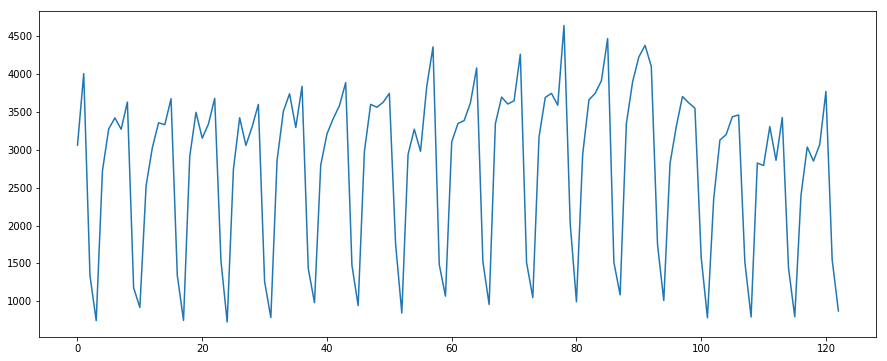

In [64]:
events_day_counts = events.groupby(['year', 'month','day']).size()

plt.figure(figsize = (15,6)) 
plt.plot(events_day_counts.values)

#### Observation:

There is clear seasonality. Interval seems to be 7 days.

### Weekly trend

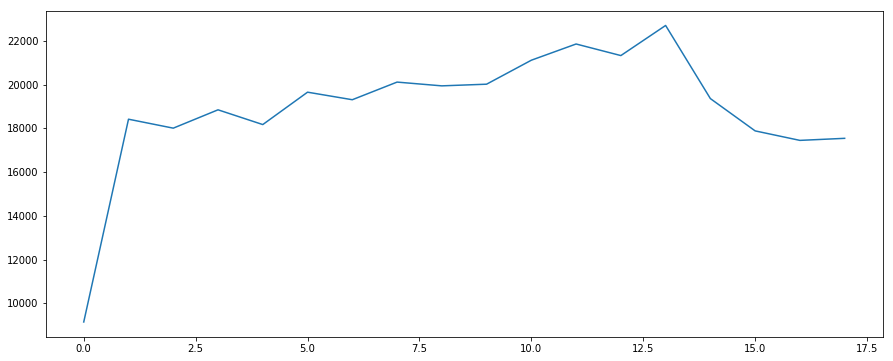

In [88]:
events_week_counts = events.groupby(['year','week']).size()

plt.figure(figsize = (15,6)) 
plt.plot(events_week_counts.values)

### Trend for different event type

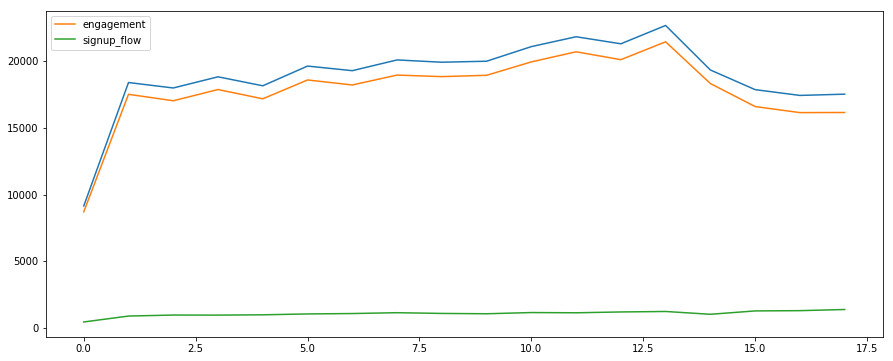

In [149]:
events_week_counts = events.groupby(['week']).size()

events_week_counts_type = events.groupby(['event_type', 'week'], as_index=False).size().reset_index(name='counts')
events_week_counts_type_1 = events_week_counts_type[events_week_counts_type['event_type'] == 'engagement']
events_week_counts_type_2 = events_week_counts_type[events_week_counts_type['event_type'] == 'signup_flow']

plt.figure(figsize = (15,6)) 
plt.plot(events_week_counts.values)
plt.plot(events_week_counts_type_1.counts.values, label = 'engagement')
plt.plot(events_week_counts_type_2.counts.values, label = 'signup_flow')

plt.legend(loc='upper left')

#### Observation:

Engagement events count for most total events decrease.

### Trend for different event name

In [82]:
events_week_counts_name = events.groupby(['event_name', 'week'], as_index=False).size().reset_index(name='counts')

In [84]:
events_week_counts_name.event_name.unique()

array(['complete_signup', 'create_user', 'enter_email', 'enter_info',
       'home_page', 'like_message', 'login', 'search_autocomplete',
       'search_click_result_1', 'search_click_result_10',
       'search_click_result_2', 'search_click_result_3',
       'search_click_result_4', 'search_click_result_5',
       'search_click_result_6', 'search_click_result_7',
       'search_click_result_8', 'search_click_result_9', 'search_run',
       'send_message', 'view_inbox'], dtype=object)

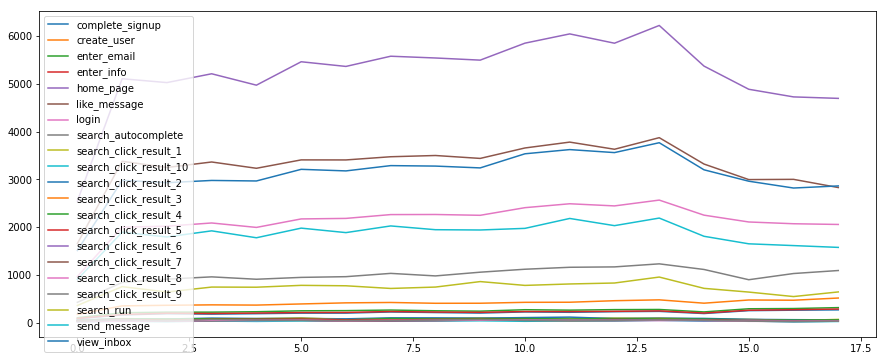

In [86]:
plt.figure(figsize = (15,6))

for event_name in list(events_week_counts_name.event_name.unique()):
    events_week_counts_name_1 = events_week_counts_name[events_week_counts_name['event_name'] == event_name]
    plt.plot(events_week_counts_name_1.counts.values, label = event_name)

plt.legend(loc='upper left')

#### Observation:

All events have similar trend.

### Trend for different different devices

In [94]:
events_week_counts_device = events.groupby(['device', 'week'], as_index=False).size().reset_index(name='counts')
events_week_counts_device.head()

,device,week,counts
0,acer aspire desktop,18,83
1,acer aspire desktop,19,319
2,acer aspire desktop,20,254
3,acer aspire desktop,21,236
4,acer aspire desktop,22,329


In [95]:
events_week_counts_device.device.unique()

array(['acer aspire desktop', 'acer aspire notebook', 'amazon fire phone',
       'asus chromebook', 'dell inspiron desktop',
       'dell inspiron notebook', 'hp pavilion desktop', 'htc one',
       'ipad air', 'ipad mini', 'iphone 4s', 'iphone 5', 'iphone 5s',
       'kindle fire', 'lenovo thinkpad', 'mac mini', 'macbook air',
       'macbook pro', 'nexus 10', 'nexus 5', 'nexus 7', 'nokia lumia 635',
       'samsumg galaxy tablet', 'samsung galaxy note',
       'samsung galaxy s4', 'windows surface'], dtype=object)

In [103]:
events_week_counts_device.week.unique()

array([18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35], dtype=int64)

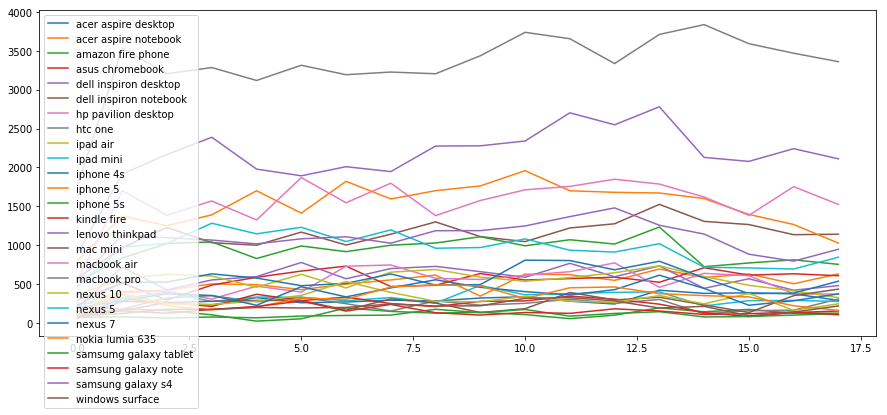

In [96]:
plt.figure(figsize = (15,6))

for device in list(events_week_counts_device.device.unique()):
    events_week_counts_device_1 = events_week_counts_device[events_week_counts_device['device'] == device]
    plt.plot(events_week_counts_device_1.counts.values, label = device)

plt.legend(loc='upper left')

In [106]:
events_week_counts_device[events_week_counts_device['week'] == 35].sort_values('counts', ascending=False).head(5)

,device,week,counts
323,macbook pro,35,3358
269,lenovo thinkpad,35,2111
305,macbook air,35,1525
107,dell inspiron notebook,35,1143
215,iphone 5,35,1029


#### Observation:

There is a clear decrease trend for lenovo thinkpad users.

### Trend for different different location

In [107]:
events_week_counts_location = events.groupby(['location', 'week'], as_index=False).size().reset_index(name='counts')

In [108]:
events_week_counts_location.location.unique()

array(['Argentina', 'Australia', 'Austria', 'Belgium', 'Brazil', 'Canada',
       'Chile', 'Colombia', 'Denmark', 'Egypt', 'Finland', 'France',
       'Germany', 'Greece', 'Hong Kong', 'India', 'Indonesia', 'Iran',
       'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Korea', 'Malaysia',
       'Mexico', 'Netherlands', 'Nigeria', 'Norway', 'Pakistan',
       'Philippines', 'Poland', 'Portugal', 'Russia', 'Saudi Arabia',
       'Singapore', 'South Africa', 'Spain', 'Sweden', 'Switzerland',
       'Taiwan', 'Thailand', 'Turkey', 'United Arab Emirates',
       'United Kingdom', 'United States', 'Venezuela'], dtype=object)

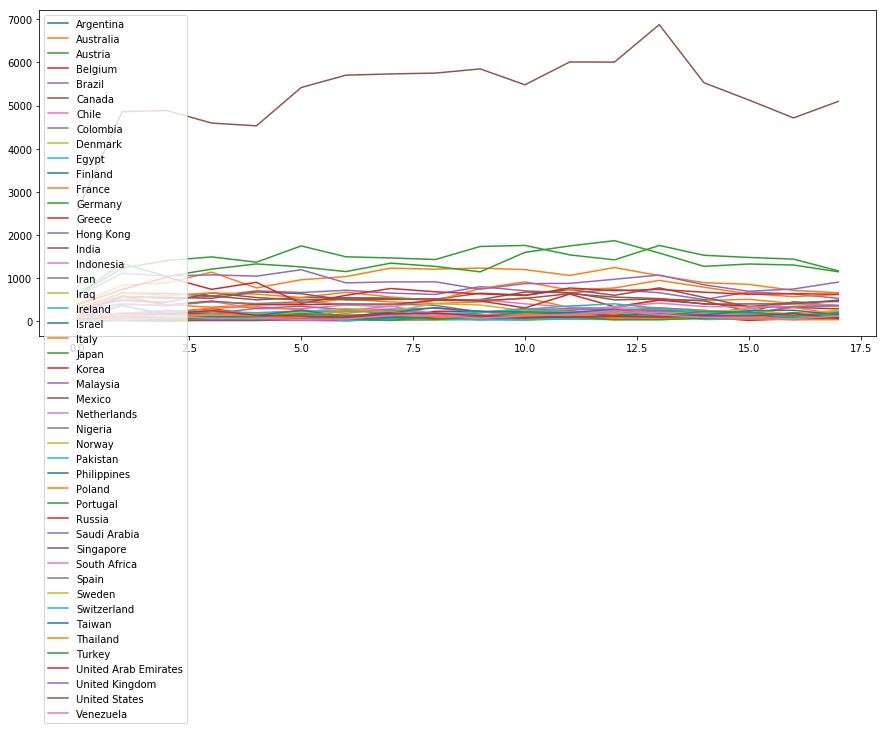

In [150]:
plt.figure(figsize = (15,6))

for location in list(events_week_counts_location.location.unique()):
    events_week_counts_location_1 = events_week_counts_location[events_week_counts_location['location'] == location]
    plt.plot(events_week_counts_location_1.counts.values, label = location)

plt.legend(loc='upper left')

#### Observation:

Most users are in US. There is a clear decrease trend for US user events.

### Trend for different different companies

In [129]:
len(users.company_id.unique())

13198

In [132]:
users.company_id.value_counts().head(10)

1.0     1036
2.0      477
3.0      307
4.0      220
5.0      172
6.0      151
8.0      129
7.0      122
9.0       96
10.0      86
Name: company_id, dtype: int64

In [125]:
mpt = pd.merge(events, users, on='user_id', how = 'left')

In [126]:
mpt.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,year,month,day,week,created_at,company_id,language,activated_at,state
0,10522.0,2014-05-02 11:02:39,engagement,login,Japan,dell inspiron notebook,3.0,2014,5,2,18,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
1,10522.0,2014-05-02 11:02:53,engagement,home_page,Japan,dell inspiron notebook,3.0,2014,5,2,18,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
2,10522.0,2014-05-02 11:03:28,engagement,like_message,Japan,dell inspiron notebook,3.0,2014,5,2,18,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
3,10522.0,2014-05-02 11:04:09,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014,5,2,18,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active
4,10522.0,2014-05-02 11:03:16,engagement,search_run,Japan,dell inspiron notebook,3.0,2014,5,2,18,2014-04-04 16:48:03,1147.0,japanese,2014-04-04 16:49:36,active


In [135]:
events_week_counts_company = mpt.groupby(['company_id', 'week'], as_index=False).size().reset_index(name='counts')

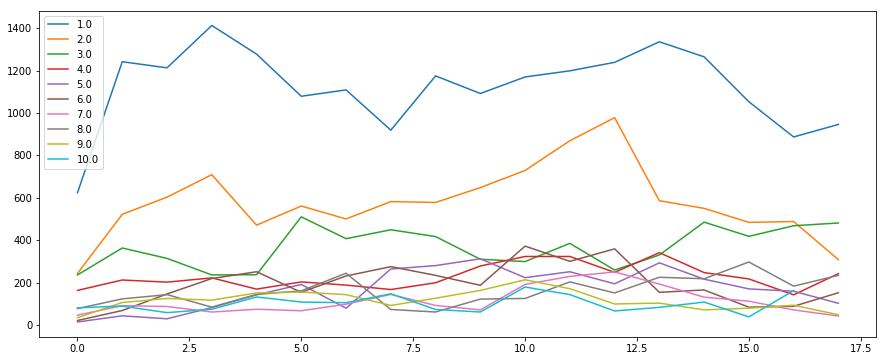

In [146]:
plt.figure(figsize = (15,6))

for company_id in list(events_week_counts_company.company_id.unique())[:10]:
    events_week_counts_company_1 = events_week_counts_company[events_week_counts_company['company_id'] == company_id]
    plt.plot(events_week_counts_company_1.counts.values, label = company_id)

plt.legend(loc='upper left')

#### Observation:

There is a clear decrease trend for company No.2.

### Trend for email events

In [140]:
emails['occurred_at'] =  pd.to_datetime(emails['occurred_at'], format='%Y-%m-%d %H:%M:%S')

emails['year'], emails['month'], emails['week'], emails['day'] = \
emails['occurred_at'].dt.year, emails['occurred_at'].dt.month, emails['occurred_at'].dt.week, emails['occurred_at'].dt.day
emails.head(2)

,user_id,occurred_at,action,user_type,year,month,week,day
0,0.0,2014-05-06 09:30:00,sent_weekly_digest,1.0,2014,5,19,6
1,0.0,2014-05-13 09:30:00,sent_weekly_digest,1.0,2014,5,20,13


In [142]:
emails_week_counts_action = emails.groupby(['action', 'week'], as_index=False).size().reset_index(name='counts')

In [144]:
emails_week_counts_action.head()

,action,week,counts
0,email_clickthrough,18,187
1,email_clickthrough,19,434
2,email_clickthrough,20,479
3,email_clickthrough,21,498
4,email_clickthrough,22,453


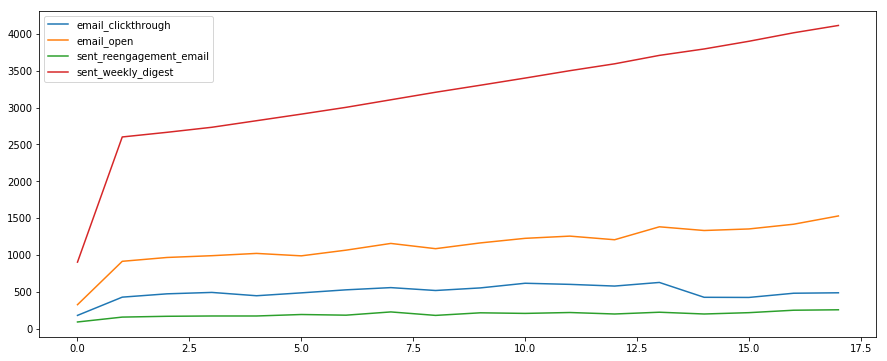

In [147]:
plt.figure(figsize = (15,6))

for action in list(emails_week_counts_action.action.unique()):
    emails_week_counts_action_1 = emails_week_counts_action[emails_week_counts_action['action'] == action]
    plt.plot(emails_week_counts_action_1.counts.values, label = action)

plt.legend(loc='upper left')

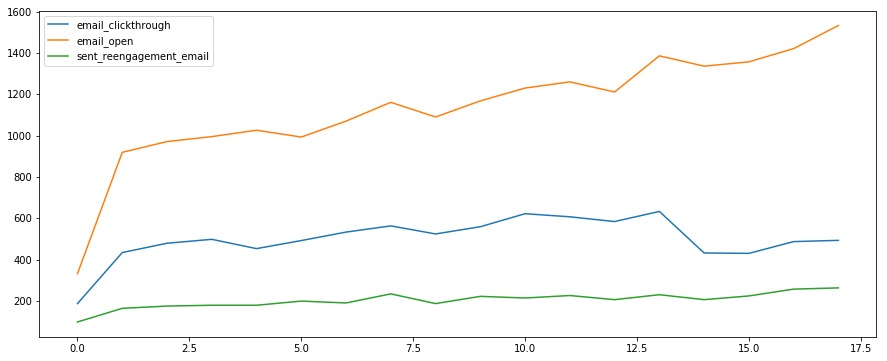

In [148]:
plt.figure(figsize = (15,6))

for action in list(emails_week_counts_action.action.unique())[:-1]:
    emails_week_counts_action_1 = emails_week_counts_action[emails_week_counts_action['action'] == action]
    plt.plot(emails_week_counts_action_1.counts.values, label = action)

plt.legend(loc='upper left')

#### Observation:

Number of ‘email_clickthrough’ decreased around week 14, while the number of email-opens did not change. The total number of ‘events’ decrease probably was caused by the decrease of number of ‘email_clickthrough’ around week 14. There might be some tech issue with the link in these emails or the contents is not attractive enough.


### There is some issue for users in company No.2 to open link in the email on thire lenovo thinkpad?